<a href="https://colab.research.google.com/github/maxxx580/tripadvisor-hotel-reviews/blob/master/Minneapolis_Tripadvisor_Hotel_Review_Sentimental_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Minneapolis Tripadvisor Hotel Review Sentimental Analysis

# Data 

In [0]:
!pip install wget
!pip install wordcloud
!pip install twython 

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=2979629e81de1a64502c5d139e6974fe5156371c0d29578ca21ef9bf9a09eea7
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
  Created wheel for twython: filename=twython-3.7.0-cp36-none-any.whl size=31995 sha256=eb8f403dc575e914567a1631232f5a529dafdd1b1ca14a44ce6a3201180d0f99
  Stored in directory: /root/.cache/pip/wheels/c2/b0/a3/5c4b4b87b8c9e4d99f1494a0b471f0134a74e5fb33d426d009
Successfully built twython


In [0]:
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import sklearn.metrics as metrics
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import sklearn
import random
import wget
import os
import nltk
import math
import re

In [0]:
random.seed(73)

In [0]:
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [0]:
wget.download("https://github.com/maxxx580/tripadvisor-hotel-reviews/archive/master.zip")
!unzip tripadvisor-hotel-reviews-master.zip
REVIEWS_DIR = "tripadvisor-hotel-reviews-master"
REVIEWS_FILE = 'reviews.csv'
!ls {REVIEWS_DIR}

Archive:  tripadvisor-hotel-reviews-master.zip
58d2f77acc842e80814b336a084bf0b3d9e5c7e4
   creating: tripadvisor-hotel-reviews-master/
  inflating: tripadvisor-hotel-reviews-master/reviews.csv  
reviews.csv


In [0]:
fields = ['file_name', 'hotel_name', 'review', 'score', 'sentiment']
reviews_df = pd.read_csv(os.path.join(REVIEWS_DIR, REVIEWS_FILE), names=fields)
reviews_df = reviews_df.drop('file_name', 1)
reviews_df.tail()

,hotel_name,review,score,sentiment
3321,Hyatt Regency Minneapolis,"""The staff was friendly, efficient and informa...",4,positive
3322,Hyatt Regency Minneapolis,"""Purchased a Deluxe King Room. Was given a De...",1,negative
3323,Hyatt Regency Minneapolis,"""Stayed here during a business trip. Have sta...",5,positive
3324,Hyatt Regency Minneapolis,"""This is a very nice hotel. Spacious, clean ro...",4,positive
3325,Hyatt Regency Minneapolis,"""We live in Connecticut. We were in for our da...",3,negative


In [0]:
num_hotels = len(reviews_df.hotel_name.unique())
print("number of hotel parsed: %d" % num_hotels)
reviews_df.hotel_name.unique()

number of hotel parsed: 50


array(['Embassy Suites by Hilton Minneapolis Downtown',
       'W Minneapolis - The Foshay',
       'Hampton Inn and Suites Minneapolis University Area',
       '300 Clifton', 'AC Hotel Minneapolis Downtown', 'Hewing Hotel',
       'Radisson Red Minneapolis', 'Emery Hotel, Autograph Collection',
       'Doubletree by Hilton Minneapolis - University Area',
       'Aloft Minneapolis', 'LeBlanc House Bed and Breakfast',
       'Evelo&#39;s Bed and Breakfast', 'Alma Hotel', 'University Inn',
       'Minneapolis International Hostel', 'Lakeland Inn',
       'Snelling Motel', 'Aqua City Motel', 'The Wales House',
       'Hilton Minneapolis', 'Hilton Garden Inn Minneapolis Downtown',
       'Holiday Inn Express Minneapolis Downtown (Convention Center)',
       'InterContinental Minneapolis - St. Paul Airport',
       'Luminn Hotel Minneapolis', 'Moxy Minneapolis Uptown',
       'Elliot Park Hotel, Autograph Collection',
       'Delta Hotels by Marriott Minneapolis Northeast',
       'Canopy b

In [0]:
reviews_df["hotel_name"].value_counts()

Le Meridien Chambers Minneapolis                                100
Embassy Suites by Hilton Minneapolis Downtown                   100
Hyatt Place Minneapolis/Downtown                                100
Loews Minneapolis Hotel                                         100
Hilton Garden Inn Minneapolis Downtown                          100
Hewing Hotel                                                    100
Holiday Inn Express Minneapolis Downtown (Convention Center)    100
Residence Inn Minneapolis Downtown at The Depot                 100
Best Western Plus The Normandy Inn &amp; Suites                 100
Hilton Minneapolis                                              100
Doubletree by Hilton Minneapolis - University Area              100
AC Hotel Minneapolis Downtown                                   100
Renaissance Minneapolis Hotel, The Depot                        100
TownePlace Suites Minneapolis Downtown/North Loop               100
Emery Hotel, Autograph Collection               

In [0]:
reviews_df = reviews_df.groupby('hotel_name').filter(lambda x : len(x)>=20)

Compute average Vader sentiment and average ground truth rating per hotel.  

In [0]:
def evalSentences(sentences):
    sid = SentimentIntensityAnalyzer()
    pdlist = []
    for sentence in tqdm(sentences):
        ss = sid.polarity_scores(sentence)
        pdlist.append(ss['compound'])
    return pdlist

In [0]:
reviews_df['vader_sentiment'] = evalSentences(reviews_df.review)
reviews_df['sentiment'] = [1 if x == 'positive' else -1 for x in reviews_df.sentiment]
reviews_df.tail()

100%|██████████| 3250/3250 [00:03<00:00, 863.19it/s]


,hotel_name,review,score,sentiment,vader_sentiment
3321,Hyatt Regency Minneapolis,"""The staff was friendly, efficient and informa...",4,1,0.8381
3322,Hyatt Regency Minneapolis,"""Purchased a Deluxe King Room. Was given a De...",1,-1,-0.6369
3323,Hyatt Regency Minneapolis,"""Stayed here during a business trip. Have sta...",5,1,0.9752
3324,Hyatt Regency Minneapolis,"""This is a very nice hotel. Spacious, clean ro...",4,1,0.2484
3325,Hyatt Regency Minneapolis,"""We live in Connecticut. We were in for our da...",3,-1,-0.4005


In [0]:
reviews_df.groupby('hotel_name').mean().score

hotel_name
AC Hotel Minneapolis Downtown                                   4.460000
Aloft Minneapolis                                               3.870000
Best Western Plus The Normandy Inn &amp; Suites                 4.480000
Canopy by Hilton Minneapolis Mill District                      4.433735
Courtyard by Marriott Minneapolis Downtown                      4.200000
Crowne Plaza Northstar                                          3.560000
Days Hotel by Wyndham University Ave SE                         3.600000
Delta Hotels by Marriott Minneapolis Northeast                  4.200000
Doubletree by Hilton Minneapolis - University Area              3.750000
Elliot Park Hotel, Autograph Collection                         4.250000
Embassy Suites by Hilton Minneapolis Downtown                   4.380000
Emery Hotel, Autograph Collection                               3.850000
Hampton Inn &amp; Suites Minneapolis/Downtown                   4.240000
Hampton Inn and Suites Minneapolis Unive

 
Rank hotels by average ground truth sentiment

In [0]:
hotel_average = reviews_df.groupby('hotel_name').mean()
hotel_average.sort_values(by=['score']).tail()

,score,sentiment,vader_sentiment
hotel_name,,,
Best Western Plus The Normandy Inn &amp; Suites,4.48,0.82,0.791786
Hilton Garden Inn Minneapolis Downtown,4.53,0.80,0.841146
The Wales House,4.65,0.80,0.946625
Hampton Inn and Suites Minneapolis University Area,4.65,0.84,0.856227
LeBlanc House Bed and Breakfast,4.80,0.80,0.965125


Average Vader Compound Sentiment Score

In [0]:
hotel_average.sort_values(by=['vader_sentiment']).tail()

,score,sentiment,vader_sentiment
hotel_name,,,
Delta Hotels by Marriott Minneapolis Northeast,4.20,0.7,0.866940
Residence Inn Minneapolis Downtown at The Depot,4.24,0.7,0.885389
The Wales House,4.65,0.8,0.946625
"Elliot Park Hotel, Autograph Collection",4.25,0.7,0.949985
LeBlanc House Bed and Breakfast,4.80,0.8,0.965125


Top 5 mean sentiment does not completely agree with top 5 mean vader sentiment. Only 2 hotel show up in both top 5 LeBlanc House Bed and Breakfast and The Wales House. 

Use term frequency of the words for (i) positive reviews and (ii) negative with ground truth sentiment to rank the top-50 most frequent non-stopwords in the review collection. 

In [0]:
positive_reviews_df = reviews_df[reviews_df.sentiment == 1].copy()
negative_reviews_df = reviews_df[reviews_df.sentiment == -1].copy()

In [0]:
def review_tokennize(reviews):
    tokenized = []
    tokenizer = RegexpTokenizer('\s+', gaps=True)
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    for review in tqdm(reviews):
        new_text = re.sub(r'[^A-Za-z0-9 \s \# \@]+', '', review)
        new_text = re.sub(r'\d+', '', new_text)
        new_text = re.sub(r'\n', ' ', new_text)
        new_text = new_text.lower()
        new_text = re.sub(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*', 
                          '', new_text)
        new_text = [lemmatizer.lemmatize(token, 'v') for token in new_text.split()]
        new_text = re.sub(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*', 
                          '', ' '.join(new_text))
        new_text = tokenizer.tokenize(new_text)
        tokenized.append(new_text)
    return tokenized

def get_term_count(records):
    cnt = Counter()
    for record in tqdm(records):
        cnt.update(record)
    return cnt

In [0]:
positive_reviews_df['tokenized_review'] = review_tokennize(positive_reviews_df.review)
negative_reviews_df['tokenized_review'] = review_tokennize(negative_reviews_df.review)
positive_counter = get_term_count(positive_reviews_df.tokenized_review.values)
negative_counter = get_term_count(negative_reviews_df.tokenized_review.values)

100%|██████████| 739/739 [00:00<00:00, 54137.54it/s]


#### Positive word count

In [0]:
positive_counter.most_common(50)

[('room', 2971),
 ('hotel', 2826),
 ('stay', 2252),
 ('great', 1694),
 ('staff', 1439),
 ('nice', 1116),
 ('clean', 1072),
 ('walk', 950),
 ('park', 862),
 ('location', 833),
 ('good', 825),
 ('would', 820),
 ('friendly', 751),
 ('breakfast', 740),
 ('get', 740),
 ('minneapolis', 739),
 ('downtown', 693),
 ('bed', 659),
 ('comfortable', 650),
 ('us', 646),
 ('service', 627),
 ('time', 589),
 ('go', 588),
 ('place', 549),
 ('also', 545),
 ('one', 544),
 ('area', 531),
 ('bar', 528),
 ('make', 526),
 ('well', 525),
 ('helpful', 518),
 ('check', 476),
 ('night', 475),
 ('desk', 455),
 ('like', 452),
 ('front', 422),
 ('need', 401),
 ('close', 394),
 ('really', 394),
 ('food', 381),
 ('restaurants', 378),
 ('recommend', 370),
 ('lobby', 368),
 ('lot', 367),
 ('love', 364),
 ('back', 355),
 ('restaurant', 353),
 ('take', 347),
 ('could', 336),
 ('use', 335)]

#### Negative word count

In [0]:
negative_counter.most_common(50)

[('room', 1349),
 ('hotel', 1053),
 ('stay', 691),
 ('get', 479),
 ('would', 412),
 ('one', 366),
 ('go', 359),
 ('desk', 351),
 ('staff', 323),
 ('front', 304),
 ('time', 303),
 ('night', 294),
 ('park', 289),
 ('check', 284),
 ('say', 275),
 ('good', 268),
 ('nice', 265),
 ('us', 264),
 ('clean', 263),
 ('bed', 250),
 ('like', 242),
 ('make', 235),
 ('service', 232),
 ('call', 231),
 ('ask', 228),
 ('tell', 225),
 ('even', 214),
 ('breakfast', 212),
 ('location', 210),
 ('need', 209),
 ('great', 196),
 ('give', 195),
 ('place', 194),
 ('could', 188),
 ('come', 183),
 ('also', 179),
 ('back', 177),
 ('leave', 175),
 ('area', 174),
 ('work', 167),
 ('walk', 166),
 ('bar', 160),
 ('find', 160),
 ('use', 158),
 ('take', 157),
 ('floor', 155),
 ('never', 151),
 ('next', 146),
 ('bathroom', 145),
 ('pay', 144)]

Positive reviews has a high frequency location term "downtown" and "minneapolis". Other aspects that are commonly being reviewed include cleanness, breakfast, parking, bed, and restaurants etc.    

There is no location term shows up in negative review. Negative reviews focus on issues such as bathroom, cost, breakfast, bar,cleanness, etc.    

In general, positive reviews has much higher term frequency than negative term (almost twice many), which is likely due to there are more positive review than negative ones. 

In [0]:
# citation: https://medium.com/greyatom/learning-pos-tagging-chunking-in-nlp-85f7f811a8cb
# Noun Phrase Extraction Support Functions
from nltk.corpus import stopwords
stopwords_english = stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case... 
def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopwords_english)
    return accepted

# generator, create item once a time
def get_terms(tree):
    for leaf in leaves(tree):
        term = [normalise(w) for w,t in leaf if acceptable_word(w) ]
        # Phrase only
        if len(term)>1:
            yield term

def flatten(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

def get_noun_phrases(tokenized_reviews):
    noun_phrases = []
    grammar = ('''NP: {<DT>?<JJ>*<NN>} # NP''')
    grammar2 = ('''NP: {<DT>?<JJ>*<NN>} # NP''')
    grammar3 = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
    """
    chunk_parser = nltk.RegexpParser(grammar3)

    for review in tqdm(tokenized_reviews):
        # sub = []
        # review_tagged = nltk.pos_tag(review)
        # for s_tree in chunk_parser.parse(review_tagged).subtrees():
         #   if s_tree.label() == 'NP' or s_tree.label() == 'JJ' or s_tree.label() == 'RB':
         #       sub.append(' '.join(leaf[0] for leaf in s_tree.leaves()))
        temp = re.findall(r'\w+', str(review))
        noun_phrases.append(flatten([word for word in get_terms(chunk_parser.parse(nltk.pos_tag(temp))) ])) 
    return noun_phrases

In [0]:
positive_noun_phrases = get_noun_phrases(positive_reviews_df.review.values)
negative_noun_phrases = get_noun_phrases(negative_reviews_df.review.values)
positive_noun_phrases_cnt = get_term_count(positive_noun_phrases)
negative_noun_phrases_cnt = get_term_count(negative_noun_phrases)

100%|██████████| 739/739 [00:00<00:00, 220470.21it/s]


In [0]:
positive_noun_phrases_cnt.most_common(50)

[('front desk', 176),
 ('downtown minneapoli', 118),
 ('great locat', 113),
 ('light rail', 75),
 ('target field', 70),
 ('great place', 65),
 ('front desk staff', 56),
 ('u bank stadium', 55),
 ('convent center', 55),
 ('hot tub', 52),
 ('target center', 47),
 ('first time', 44),
 ('friendli staff', 43),
 ('hotel room', 42),
 ('nthe room', 41),
 ('twin game', 39),
 ('short walk', 38),
 ('nice hotel', 37),
 ('nthe hotel', 37),
 ('room servic', 35),
 ('minut walk', 34),
 ('hotel staff', 32),
 ('great stay', 31),
 ('great experi', 31),
 ('busi trip', 30),
 ('comfort bed', 30),
 ('great hotel', 29),
 ('twin citi', 29),
 ('hampton inn', 29),
 ('valet park', 27),
 ('top notch', 26),
 ('next day', 25),
 ('free park', 25),
 ('great time', 24),
 ('good locat', 24),
 ('night stay', 24),
 ('easi access', 23),
 ('good valu', 23),
 ('clean room', 23),
 ('downtown area', 23),
 ('shuttl servic', 23),
 ('custom servic', 23),
 ('park garag', 23),
 ('great restaur', 22),
 ('great view', 22),
 ('univers

In [0]:
negative_noun_phrases_cnt.most_common(50)

[('front desk', 167),
 ('next morn', 26),
 ('front desk staff', 21),
 ('custom servic', 21),
 ('downtown minneapoli', 20),
 ('nthe room', 19),
 ('good locat', 18),
 ('room servic', 17),
 ('next day', 17),
 ('free breakfast', 16),
 ('park lot', 16),
 ('great locat', 16),
 ('first night', 14),
 ('credit card', 12),
 ('nthe hotel', 12),
 ('pool area', 12),
 ('hotel room', 12),
 ('last time', 11),
 ('night stay', 11),
 ('hot water', 10),
 ('shuttl servic', 10),
 ('bar area', 9),
 ('hotel staff', 9),
 ('next time', 9),
 ('long time', 9),
 ('nice hotel', 8),
 ('good thing', 8),
 ('corner room', 8),
 ('secur guard', 8),
 ('mani peopl', 8),
 ('lobbi area', 8),
 ('last night', 8),
 ('staff member', 8),
 ('free park', 7),
 ('key card', 7),
 ('beauti hotel', 7),
 ('busi travel', 7),
 ('good hotel', 7),
 ('coffe maker', 7),
 ('hotel bar', 7),
 ('counter space', 7),
 ('u bank stadium', 7),
 ('light rail', 7),
 ('hotel manag', 7),
 ('differ room', 7),
 ('phone call', 7),
 ('hotel stay', 7),
 ('air c

Noun phrase is more infomative than the words. In positive reviews, there are location term like downtown minneapoli, target field, us bank stadium, and target center. it is reasonable to concludes that traveller likes the hotel because of their location, great amenities such as hot tub, and service like free airport shuttle or free breakfast. 

Location term downtown minneapoli and us bank stadium also frequently shows up in negative reviews. Traveller dislike the hotel mostly because of bad experience interacting with hotel staff. Interestedly, some terms with positive sentiment also shows un such as good hote or great location. 

Use mutual information (MI) with ground truth sentiment to rank the top-50 most sentiment- bearing non-stopwords in the review collection.

In [0]:
def sample_vocabulary(total, topk=2000, low_sample_rate=0.1):
    topk_terms = total.most_common(topk)
    low_freq_terms = [x for x in total if x not in topk_terms]
    return [*topk_terms] + random.sample(low_freq_terms,
                                         math.floor(len(low_freq_terms)*low_sample_rate))

In [0]:
def create_sentiments2terms(df, topk, column):
    records = []
    for tokens in tqdm(df[column].values):
        token_set = set(tokens)
        records.append([1 if w in token_set else 0 for w in topk])
    terms_df = pd.DataFrame(records, columns=topk)
    return pd.concat([df[['sentiment']], terms_df], axis=1)


def getMI(topk, df, label_column='sentiment'):
    miScore = []
    for word in tqdm(topk):
        miScore.append([word]+[metrics.mutual_info_score(df[label_column], df[word])])
    miScoredf = pd.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Word','MI Score']
    return miScoredf

In [0]:
reviews_df['tokenized_review'] = review_tokennize(reviews_df.review.values)
noun_vocabulary = [*get_term_count(reviews_df.tokenized_review.values)]
words_sentiments_df = create_sentiments2terms(reviews_df, noun_vocabulary, 'tokenized_review')
word_mi_df = getMI(noun_vocabulary, words_sentiments_df)
word_mi_df.sort_values(by=['MI Score']).tail(50)

100%|██████████| 11468/11468 [00:17<00:00, 649.58it/s]


,Word,MI Score
549,excellent,0.023627
166,around,0.023733
49,one,0.023807
138,us,0.023845
52,go,0.023859
15,close,0.023921
301,lobby,0.023948
84,back,0.023953
62,small,0.023956
1017,river,0.024099


There are a few location related terms such as downtown, minneapolis, university and river. Most of the high MI unigram, such as clean, friendly, or beautiful reveals positive sentiments. None of these terms reveals obvious negative sentiments.    

Based on these high MI unigrams, it is reasonable to conclude that traveller likes the hotel because of the friendly staff, location, and good food. 

Repeat this analysis for the top-50 noun phrases and note any interesting results

In [0]:
reviews_df['noun_phrases'] = get_noun_phrases(reviews_df.tokenized_review.values)
noun_phrase_volcabulary = [*get_term_count(reviews_df.noun_phrases.values)]
noun_phrases_sentiments_df = create_sentiments2terms(reviews_df, noun_phrase_volcabulary, 'noun_phrases')
noun_phrase_mi_df = getMI(noun_phrase_volcabulary, noun_phrases_sentiments_df)
noun_phrase_mi_df.sort_values(by=['MI Score']).tail(50)

100%|██████████| 23155/23155 [00:35<00:00, 650.18it/s]


,Word,MI Score
12866,front door charm entri vintag glass elev seat ...,0.016518
12865,rush car total relax yard,0.016518
12864,pull wait line mani downtown hotel,0.016518
12863,picturesqu build love french countri,0.016518
12862,your minneapoli,0.016518
12861,walk path,0.016518
12860,great street,0.016518
12859,nicollet inn wonder area lot,0.016518
12858,walk distanc downtown minneapoli,0.016518
12857,town overnight hotel pricey histor beauti ampl...,0.016518


The high MI noun phrases can reveal that trallver like the hotel beacuse of its food. Only one location related term shows up which is minneapolis. it is also noted that noun of these noun phrases carry obvious negative sentiments.  

For ground truth sentiment, calculate the top-50 words according to PMI of the word occuring with (i) positive reviews and (ii) negative reviews. 


In [0]:
# negative_reviews_df
def pmiCal(df, x):
    pmilist=[]
    for i in [-1,1]:
        for j in [0,1]:
            px = sum(df['sentiment']==i)/len(df)
            py = (sum(df[x]==j)+1)/len(df)
            pxy = len(df[(df['sentiment']==i) & (df[x]==j)])/len(df)
            if pxy==0:#Log 0 cannot happen
                pmi = math.log((pxy+0.0001)/(px*py))
            else:
                pmi = math.log(pxy/(px*py))
            pmilist.append([i]+[j]+[px]+[py]+[pxy]+[pmi])
    pmidf = pd.DataFrame(pmilist)
    pmidf.columns = ['x','y','px','py','pxy','pmi']
    return pmidf

def pmiIndivCal(df,x,gt, label_column='sentiment'):
    px = sum(df[label_column]==gt)/len(df)
    py = (sum(df[x]==1)+1)/len(df)
    pxy = len(df[(df[label_column]==gt) & (df[x]==1)])/len(df)
    if pxy==0:#Log 0 cannot happen
        pmi = math.log((pxy+0.0001)/(px*py))
    else:
        pmi = math.log(pxy/(px*py))
    return pmi

def pmiForAllCal(df, topk, label_column='sentiment'):
    #Try calculate all the pmi for top k and store them into one pmidf dataframe
    pmilist = []
    pmiposlist = []
    pmineglist = []
    for word in tqdm(topk):
        pmilist.append([word]+[pmiCal(df,word)])
        pmiposlist.append([word]+[pmiIndivCal(df,word,1,label_column)])
        pmineglist.append([word]+[pmiIndivCal(df,word,-1,label_column)])
    pmidf = pd.DataFrame(pmilist)
    pmiposlist = pd.DataFrame(pmiposlist)
    pmineglist = pd.DataFrame(pmineglist)
    pmiposlist.columns = ['word','pmi']
    pmineglist.columns = ['word','pmi']
    pmidf.columns = ['word','pmi']
    return pmiposlist, pmineglist, pmidf

In [0]:
selected_noun_vocabulary = [x for x, _ in get_term_count(reviews_df.tokenized_review.values).most_common(3000)]
selected_words_sentiments_df = create_sentiments2terms(reviews_df, selected_noun_vocabulary, 'tokenized_review')
pmiposlist, pmineglist, pmidf = pmiForAllCal(selected_words_sentiments_df, selected_noun_vocabulary)
pmiposlist.sort_values(by=['pmi']).tail(50)

100%|██████████| 3000/3000 [02:59<00:00, 16.67it/s]


,word,pmi
1906,steakhouse,0.163306
1905,kick,0.163306
1931,soundproof,0.163306
1933,farmers,0.163306
1545,western,0.163306
1124,text,0.163306
1940,residential,0.163306
1898,men,0.163306
1975,personality,0.163306
2019,pubs,0.163306


In [0]:
pmineglist.sort_values(by=['pmi']).tail(50)

,word,pmi
2639,bloomington,0.811081
2976,desktop,0.811081
2750,acquire,0.811081
2543,everybody,0.811081
2608,arise,0.811081
2063,nnalso,0.811081
2430,fight,0.811081
2049,banquet,0.811081
2359,scent,0.811081
2116,mood,0.811081


From the positive reviews, I can conclude that travellers like the hotel because of the amenities, food and quality of services.    
For negative reviews, it is defficult to concluses as it lack of specific terms. There are two specific location shows up "bloomington" and "milwaukee", which are cities near minneapolis. The second hightese term countryards is likely refer to the hotel "Courtyard by Marriott Minneapolis Downtown". 

## (b)

In [0]:
selected_noun_phrase_vocabulary = [x for x, _ in get_term_count(reviews_df.noun_phrases.values).most_common(3000)]
selected_noun_phrases_sentiments_df = create_sentiments2terms(reviews_df, selected_noun_phrase_vocabulary, 'noun_phrases')
pmiposlist_np, pmineglist_np, pmidf_np = pmiForAllCal(selected_noun_phrases_sentiments_df, selected_noun_phrase_vocabulary)

100%|██████████| 3000/3000 [02:43<00:00, 18.31it/s]


In [0]:
pmiposlist_np.sort_values(by=['pmi']).tail(50)

,word,pmi
240,hotel restaur,-0.006593
166,worth money,-0.006593
239,great food,-0.006593
168,second time,-0.006593
170,good room,-0.006593
173,pool area,-0.006593
140,good deal,-0.006593
84,credit card,-0.006593
175,beauti hotel,-0.006593
155,univers minnesota,-0.006593


In [0]:
pmineglist_np.sort_values(by=['pmi']).tail(50)

,word,pmi
776,wear makeup,0.811081
2517,wasnut get great custom servic,0.811081
1441,earli meet,0.811081
775,select someon,0.811081
774,light bathroom histori world,0.811081
773,idiot select lightingufmirror setup bathroom,0.811081
2516,avoid hilton brand,0.811081
772,shave bathroom,0.811081
771,makeup bathroom,0.811081
1102,sofa sleep,0.811081


For positive reviews there are high PMI location related terms such as university of minnesota, downtown minneapoli, and stone arch bridg. One of the top rated hotel "hampton inn" also presents as a high PMI term. It can be concluded that travellers write positive reviews for reasons like great location, good food, prices and services. 

For negative reviews, there is only one location related term "downtown mpl". A few hotel groups shows up such as spg and hilton. large portion of the high PMI noun phrase for negative reviews carries positive sentiment. 

In [0]:
top_rated_hotel = hotel_average.sort_values(by=['score']).tail(1).index.values[0]
bottom_rated_hotel = hotel_average.sort_values(by=['score']).head(1).index.values[-1]
print("Top rated:\t" + top_rated_hotel)
print("Bottom rated:\t" + bottom_rated_hotel)
top_hotel_df = reviews_df[reviews_df.hotel_name == top_rated_hotel]
bottom_hotel_df = reviews_df[reviews_df.hotel_name == bottom_rated_hotel]

Top rated:	LeBlanc House Bed and Breakfast
Bottom rated:	Minneapolis International Hostel


In [0]:
top_hotel_vocabulary = [x for x in get_term_count(top_hotel_df.noun_phrases.values).keys()]
top_rated_hotel_sentiments_df = create_sentiments2terms(reviews_df, top_hotel_vocabulary, 'noun_phrases')
pmiposlist_top_hotel, pmineglist_top_hotel, pmidf_top_hotel = pmiForAllCal(top_rated_hotel_sentiments_df, top_hotel_vocabulary)

100%|██████████| 199/199 [00:03<00:00, 58.11it/s]


In [0]:
pmiposlist_top_hotel.sort_values(by=['pmi']).tail(50)

,word,pmi
20,origin style whole hous way,-0.412058
11,hous hear parent review,-0.412058
57,warm review speak ampl wonder breakfast averag...,-0.412058
55,assum central air mean cool,-0.412058
59,bottom muffin averag day day,-0.412058
88,year host,-0.412058
89,chees cracker,-0.412058
90,littl delici scandinavian pastri,-0.412058
91,first bb experi im sure ive miss place,-0.412058
93,leblanc place,-0.412058


In [0]:
pmineglist_top_hotel.sort_values(by=['pmi']).tail(50)

,word,pmi
9,use din room parent host,-0.289734
8,swedish pancak,-0.289734
7,weekend breakfast,-0.289734
6,prepar fruit high qualiti coffe delici pastri,-0.289734
5,great join parent last morn impress,-0.289734
3,accommod welcom,-0.289734
31,stay memor weubll,-0.289734
147,ive stay,-0.200520
82,walk distanc,-0.177531
92,next time visit minneapoli,0.405615


People like the top rated hotel LeBlanc House Bed and Breakfast because of the food. They showed up frequently in the high PMI terms. However, it is difficult to conclude reason for negative reviews. 


In [0]:
bottom_hotel_vocabulary = [x for x in get_term_count(bottom_hotel_df.noun_phrases.values).keys()]
bottom_rated_hotel_sentiments_df = create_sentiments2terms(reviews_df, bottom_hotel_vocabulary, 'noun_phrases')
pmiposlist_bottom_hotel, pmineglist_bottom_hotel, pmidf_bottom_hotel = pmiForAllCal(bottom_rated_hotel_sentiments_df, bottom_hotel_vocabulary)

100%|██████████| 287/287 [00:05<00:00, 53.98it/s]


In [0]:
pmiposlist_bottom_hotel.sort_values(by=['pmi']).tail(50)

,word,pmi
147,cozinha para uso quarto amplosnvocuea tem,-0.412058
148,fazer amizadesna localizaueueo ue uftima poi e...,-0.412058
149,downtownngreat servic use kitchen room,-0.412058
150,opportun meet peopl world,-0.412058
151,friendsnit minut,-0.412058
152,room clean comfortablegreat commun,-0.412058
136,beauti hostel renov,-0.412058
90,contact problem phone number avail call,-0.412058
286,nnoveral hostel scari filthi old overal nightm...,-0.412058
89,sinknnno staff front desk charg care luggag of...,-0.412058


In [0]:
pmineglist_bottom_hotel.sort_values(by=['pmi']).tail(50)

,word,pmi
20,hotel standard rat,-0.289734
19,dorm ufnight hous old need work,-0.289734
42,short walk distanc hostel,-0.289734
13,hotel room,-0.287532
180,hotel locat,-0.200520
103,ive stay,-0.200520
217,great place stay,0.000150
178,great place,0.117933
279,ladi front desk,0.117933
141,locat tremend hostel great staff,0.811081


People don't like the Minneapolis International Hostel because of the old amenities, staff rudeness, refund, and prices. On the other hand, people likes the the hotel because of its location and neighborhood. 

# PMI vs MI
PMI is a better metrics in this case as it can solely focus on presence of a phrase as a predictive feature of positive or negative, rather than being distracted by absence of phrases as features. 



Show separate histograms of ground truth and Vader sentiment scores (ignore hotel ID).
Do you notice any interesting dierences?

In [0]:
def getHistogram(measure, title, df):
    if measure=='both':
        x = [df['score'].values/5]
        y = [df['vader_sentiment'].values]
        bins = np.linspace(-1, 1, 100)
        plt.title(title)
        plt.hist(x, bins, label='x')
        plt.hist(y, bins, label='y')
        plt.legend(loc='upper right')
        plt.show()
    else:
        plt.hist(df[measure].values)
        plt.title(title)
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        fig = plt.gcf()

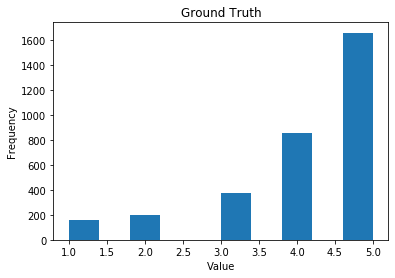

In [0]:
getHistogram('score', 'Ground Truth', reviews_df)

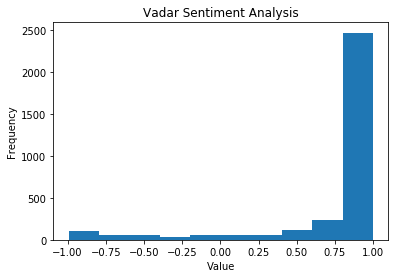

In [0]:
getHistogram('vader_sentiment', 'Vadar Sentiment Analysis', reviews_df)

Show a histogram of the number of reviews per hotel. Do you notice any interesting
trends? Are these expected?

In [0]:
count_by_hotel = reviews_df["hotel_name"].value_counts()

Text(0, 0.5, '# of count')

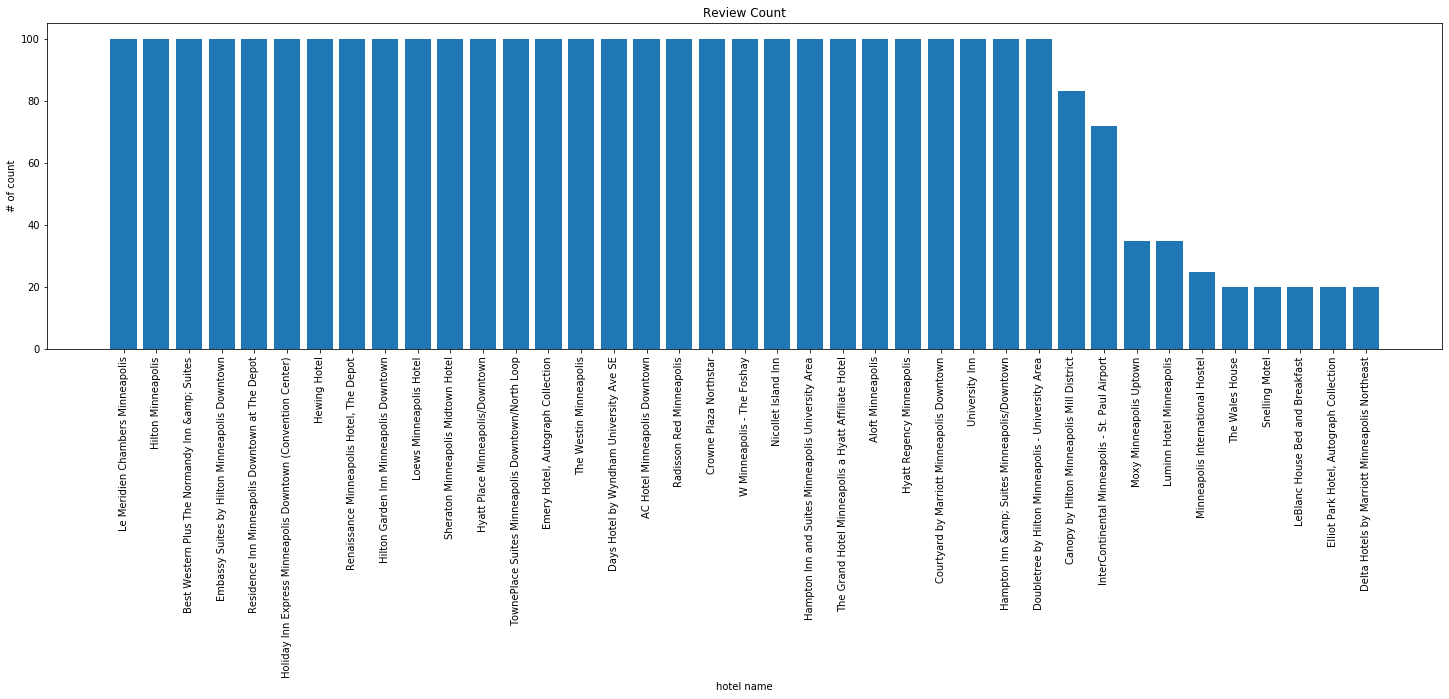

In [0]:
n = range(len(count_by_hotel))
plt.figure(figsize = (25,6))
plt.bar(n, count_by_hotel.values)
plt.title('Review Count')
plt.xticks(n, count_by_hotel.index, rotation=90)
plt.xlabel('hotel name')
plt.ylabel('# of count')

In two plots, one for ground truth star rating and one for Vader sentiment, show a plot of 5 side-by-side boxplots of these scores.

In [0]:
top5_hotels_by_average_review = reviews_df.groupby('hotel_name').mean().sort_values(by='score').index.values[-5:]
top5_vadars, top5_scores = [], []
for hotel in top5_hotels_by_average_review:
    top5_vadars.append(reviews_df[reviews_df.hotel_name == hotel].vader_sentiment)
    top5_scores.append(reviews_df[reviews_df.hotel_name == hotel].score)

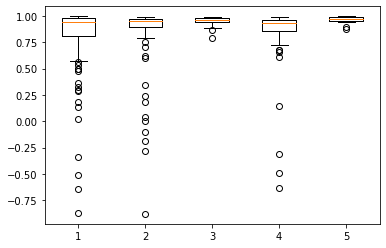

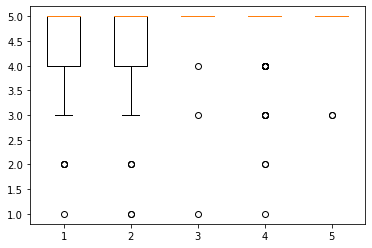

In [0]:
plt.figure()
plt.boxplot(top5_vadars)
plt.show()
plt.figure()
plt.boxplot(top5_scores)
plt.show()

Report the mean and variance of the ground truth and Vader sentiment scores for the
top-5 ranked hotels according to star rating.

In [0]:
top5_hotels_by_average_review.tolist()

['Best Western Plus The Normandy Inn &amp; Suites',
 'Hilton Garden Inn Minneapolis Downtown',
 'The Wales House',
 'Hampton Inn and Suites Minneapolis University Area',
 'LeBlanc House Bed and Breakfast']

In [0]:
def print_mean_and_variabce(hotels, data):
    print("\t\t\t mean \t\t\t variance")
    print()
    for h, d in zip(hotels, data):
        print("%s \t %f \t\t %f" % (h[:15], np.mean(d), np.var(d)))

In [0]:
print_mean_and_variabce(top5_hotels_by_average_review, top5_vadars)

			 mean 			 variance

Best Western Pl 	 0.791786 		 0.126381
Hilton Garden I 	 0.841146 		 0.097826
The Wales House 	 0.946625 		 0.002656
Hampton Inn and 	 0.856227 		 0.068423
LeBlanc House B 	 0.965125 		 0.001027


In [0]:
print_mean_and_variabce(top5_hotels_by_average_review, top5_scores)

			 mean 			 variance

Best Western Pl 	 4.480000 		 0.689600
Hilton Garden I 	 4.530000 		 0.769100
The Wales House 	 4.650000 		 0.927500
Hampton Inn and 	 4.650000 		 0.567500
LeBlanc House B 	 4.800000 		 0.360000


Plot box is a little bit more informative, as it provided information on min/max and quantiles, which cannot be drived from mean and variance. 


Show both a scatterplot and heatmap of ground truth score (star rating) versus Vader
sentiment score. Each review is a point on the scatterplot. Do you notice anything
interesting? What does this tell you about star ratings vs. Vader sentiment scores?
What does this tell you about human ratings and/or Vader sentiment analysis?

Text(0.5, 0, 'Vader Score')

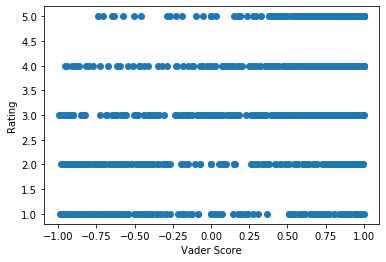

In [0]:
y = reviews_df['score'].values
x = reviews_df['vader_sentiment'].values
plt.plot(x, y,"o")
plt.ylabel('Rating')
plt.xlabel('Vader Score')

Text(0, 0.5, 'Rating')

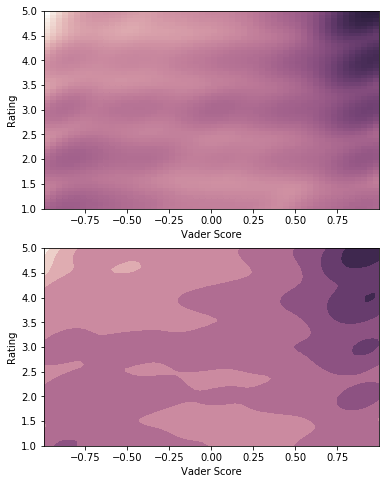

In [0]:
from scipy.stats.kde import gaussian_kde

k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(y.min(), y.max())
ax2.set_xlim(x.min(), x.max())
ax2.set_ylim(y.min(), y.max())

ax1.set_xlabel('Vader Score')
ax1.set_ylabel('Rating')

ax2.set_xlabel('Vader Score')
ax2.set_ylabel('Rating')

All grapth presents trend that vadar works well with 5 star reviews. The way people write reviews could be fairly sentiment neutral or it incldues both pros/cons in the reviews. So unless the review is completely compliment on the hotel, vadar can be misled. 

Show two scatterplots and two heatmaps of the length of reviews versus each of ground
truth score and Vader sentiment score. Each review is a point on the scatterplot. Are
there any trends?

Text(0.5, 0, 'Length')

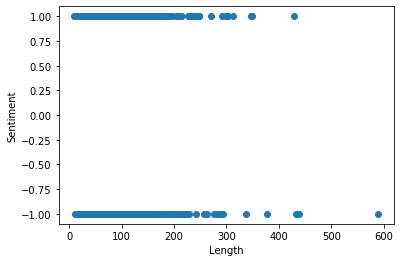

In [0]:
length = [len(x) for x in reviews_df.tokenized_review.values]
gt_sentiment = reviews_df.sentiment.values
plt.plot(length, gt_sentiment,"o")
plt.ylabel('Sentiment')
plt.xlabel('Length')


Text(0.5, 0, 'Length')

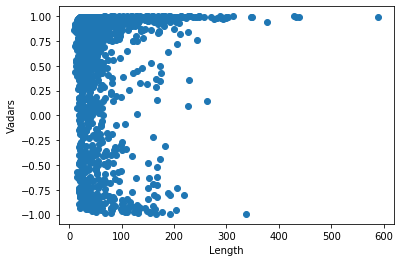

In [0]:
vadars = reviews_df.vader_sentiment.values
plt.plot(length, vadars,"o")
plt.ylabel('Vadars')
plt.xlabel('Length')

Text(0, 0.5, 'Rating')

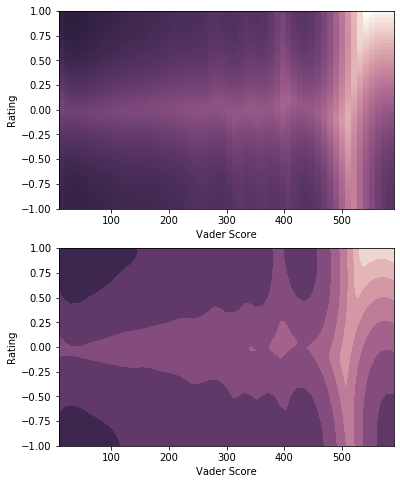

In [0]:
x = np.array(length)
y = np.array(gt_sentiment)

k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(y.min(), y.max())
ax2.set_xlim(x.min(), x.max())
ax2.set_ylim(y.min(), y.max())

ax1.set_xlabel('Vader Score')
ax1.set_ylabel('Rating')

ax2.set_xlabel('Vader Score')
ax2.set_ylabel('Rating')

Text(0, 0.5, 'Rating')

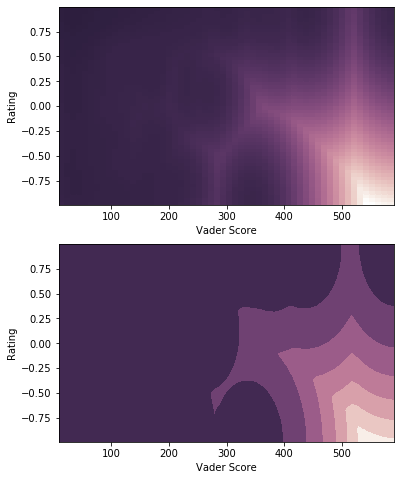

In [0]:
x = np.array(length)
y = np.array(vadars)

k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(y.min(), y.max())
ax2.set_xlim(x.min(), x.max())
ax2.set_ylim(y.min(), y.max())

ax1.set_xlabel('Vader Score')
ax1.set_ylabel('Rating')

ax2.set_xlabel('Vader Score')
ax2.set_ylabel('Rating')

There is no obvious trend between length and ground truth sentiment except for the 600 long negative review (outlier). 

There is a trend between vadar and length where longer review is more likely to get positve vadar sentiment. It is quite obvious there are more long review with a vadar sentiment of 1 than any other vadar scores. 



Show two scatterplots of the number of reviews per hotel versus each of average ground truth score and average Vader sentiment score. In this case, each hotel is a single point on the scatterplot. Are there any trends?

Text(0.5, 0, 'number of reviews by hotel')

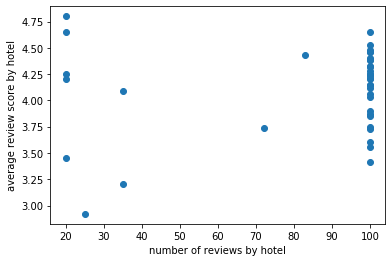

In [0]:
review_num = reviews_df["hotel_name"].value_counts()
average_per_hotel = reviews_df.groupby('hotel_name').mean()
average_score_by_hotel = [average_per_hotel.score[name] for name in review_num.index]
plt.plot(review_num, average_score_by_hotel,"o")
plt.ylabel('average review score by hotel')
plt.xlabel('number of reviews by hotel')

Text(0.5, 0, 'number of reviews by hotel')

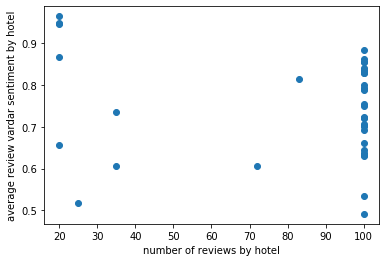

In [0]:
average_vadar_by_hotel = [average_per_hotel.vader_sentiment[name] for name in review_num.index]
plt.plot(review_num, average_vadar_by_hotel,"o")
plt.ylabel('average review vardar sentiment by hotel')
plt.xlabel('number of reviews by hotel')

There is a trend where between number of review per hotel vs its average ground truth review. The hotel is more likely to be highly rated if they have more raing. 

There is no obvisou trend between number of reviews by hotel vs average vadar scores. 

This trend might not be conclusive as the number of review per hotel is limited to 100. 